# Tracking through elements with autodiff

In [1]:
import numpy as np
import torch
from collections import namedtuple
from torch.autograd.functional import jacobian
from torch.autograd.functional import hessian
from pytao import Tao
import matplotlib.pyplot as plt
import numdifftools as nd

np.set_printoptions(precision= 16, suppress=False)
torch.set_printoptions(precision= 16, sci_mode=True)
torch.__version__, np.__version__
import sys
tkwargs = {
    "dtype" : torch.double
}
import time

# Constants

In [2]:
c_light = 2.99792458e8 #speed of light in m/s
m_e = 0.510998950e6 #electron mass in eV

# Tuples

In [3]:
Drift = namedtuple('Drift', 'L')
Quadrupole = namedtuple('Quadrupole', 'L K1 NUM_STEPS')
Particle = namedtuple('Particle', 'x px y py z pz s p0c mc2')
#Canonical phase space coordinates as defined in Bmad manual section 15.4.2. Added s t p0c and mc2 = 0

## PyTorch tensor test Particle:

In [4]:
np.random.seed(0)
pvec = np.random.rand(10_000, 6) #test particles
s = 0.0
p0c = 4.0E+07 #Reference particle momentum in eV
mc2 = 1*m_e # electron mass in eV
ts = torch.tensor(s, **tkwargs)
tp0c = torch.tensor(p0c, **tkwargs)
tmc2 = torch.tensor(mc2, **tkwargs) #necessary? 
tpvec = torch.tensor(pvec, requires_grad=True, **tkwargs)
p_torch = Particle(*tpvec.T, ts, tp0c, tmc2)
p_torch

Particle(x=tensor([5.4881350392732475e-01, 4.3758721126269251e-01, 5.6804456109393231e-01,
         ..., 1.6739176591167459e-01, 8.2838659877820775e-01,
        4.2741875758117731e-01], dtype=torch.float64,
       grad_fn=<UnbindBackward0>), px=tensor([7.1518936637241948e-01, 8.9177300078207977e-01, 9.2559663829266103e-01,
         ..., 3.5145149927123487e-01, 3.5342664838276150e-01,
        8.8324715311888191e-01], dtype=torch.float64,
       grad_fn=<UnbindBackward0>), y=tensor([6.0276337607164387e-01, 9.6366276050102928e-01, 7.1036058197886942e-02,
         ..., 2.7008431955854806e-01, 9.2013387734489693e-01,
        3.8008122694143009e-01], dtype=torch.float64,
       grad_fn=<UnbindBackward0>), py=tensor([5.4488318299689686e-01, 3.8344151882577771e-01, 8.7129299701540708e-02,
         ..., 8.7026390127975972e-02, 8.1374798653759683e-01,
        1.6900412983681179e-01], dtype=torch.float64,
       grad_fn=<UnbindBackward0>), z=tensor([4.2365479933890471e-01, 7.9172503808266459e-01,

# Drift

## `track_a_drift`

In [5]:
def make_track_a_drift(lib):
    """
    Makes track_a_drift given the library lib
    """
    
    sqrt = lib.sqrt
    
    def track_a_drift(p_in, drift):
        """
        Tracks the incoming Particle p_in though drift element
        and returns the outgoing particle. See eqs 24.58 in bmad manual
        """
        L = drift.L
        
        s = p_in.s
        p0c = p_in.p0c
        mc2 = p_in.mc2
        
        x = p_in.x
        px = p_in.px
        y = p_in.y
        py = p_in.py
        z = p_in.z
        pz = p_in.pz
        
        P = 1 + pz #Particle's total momentum over p0
        Px = px / P #Particle's 'x' momentum over p0
        Py = py / P #Particle's 'y' momentum over p0
        Pxy2 = Px**2 + Py**2 #Particle's transverse mometum^2 over p0^2
        Pl = sqrt(1-Pxy2)  #Particle's longitudinal momentum over p0
        
        x = x + L * Px / Pl
        y = y + L * Py / Pl
        
        beta = P * p0c / sqrt( (P*p0c)**2 + mc2**2) # hypot
        beta_ref = p0c / sqrt( p0c**2 + mc2**2)
        z = z + L * ( beta/beta_ref - 1.0/Pl )
        s = s + L
        
        return Particle(x, px, y, py, z, pz, s, p0c, mc2)
    
    return track_a_drift

# Specialized functions
track_a_drift_torch = make_track_a_drift(lib=torch)

## drift test

In [6]:
# Create drift
L=1.0 # Drift length in m
d1 = Drift(torch.tensor(L, **tkwargs))
type(d1).__name__

'Drift'

### One particle test

In [7]:
# Incoming particle
s = 0.0 #initial s
p0c = 4.0E+07 #Reference particle momentum in eV
mc2 = 1*m_e # electron mass in eV
ts = torch.tensor(s, **tkwargs)
tp0c = torch.tensor(p0c, **tkwargs)
tmc2 = torch.tensor(mc2, **tkwargs)
pvec1 = [2e-3,3e-3,-3e-3,-1e-3,2e-3,-2e-3] 
tvec1 = torch.tensor(pvec1, requires_grad=True, **tkwargs)
tvec1

tensor([2.0000000000000000e-03, 3.0000000000000001e-03, -3.0000000000000001e-03,
        -1.0000000000000000e-03, 2.0000000000000000e-03, -2.0000000000000000e-03],
       dtype=torch.float64, requires_grad=True)

In [8]:
# Outgoing particle
p_out = track_a_drift_torch(Particle(*tvec1,ts, tp0c, tmc2), d1)
x_me = torch.hstack([p_out.x,p_out.px,p_out.y,p_out.py,p_out.z,p_out.pz]).detach()
x_me

tensor([5.0060271145229325e-03, 3.0000000000000001e-03, -4.0020090381743109e-03,
        -1.0000000000000000e-03, 1.9946525738924175e-03, -2.0000000000000000e-03],
       dtype=torch.float64)

In [9]:
# bmad lattice for comparison
tao = Tao('-lat test_drift.bmad -noplot')
tao.cmd('set particle_start x='+str(pvec1[0]))
tao.cmd('set particle_start px='+str(pvec1[1]))
tao.cmd('set particle_start y='+str(pvec1[2]))
tao.cmd('set particle_start py='+str(pvec1[3]))
tao.cmd('set particle_start z='+str(pvec1[4]))
tao.cmd('set particle_start pz='+str(pvec1[5]))
orbit_out=tao.orbit_at_s(ele=1)
#orbit_out

In [10]:
# bmad outgoing particle
x_tao = torch.tensor([orbit_out['x'],orbit_out['px'],orbit_out['y'],orbit_out['py'],orbit_out['z'],orbit_out['pz']],**tkwargs)
x_tao

tensor([5.0060271145229299e-03, 3.0000000000000001e-03, -4.0020090381743100e-03,
        -1.0000000000000000e-03, 1.9946525738923598e-03, -2.0000000000000000e-03],
       dtype=torch.float64)

In [11]:
torch.allclose(x_me, x_tao)

True

### Jacobian test

In [12]:
f_drift = lambda x: track_a_drift_torch(Particle(*x, ts, tp0c, tmc2), d1)[:6]
J = jacobian(f_drift, tvec1)

In [13]:
# Jacobian matrix
mat_me = torch.vstack(J)
mat_me

tensor([[ 1.0000000000000000e+00,  1.0020180925273929e+00,
          0.0000000000000000e+00, -3.0181176940051169e-06,
          0.0000000000000000e+00, -3.0120814586171068e-03],
        [ 0.0000000000000000e+00,  1.0000000000000000e+00,
          0.0000000000000000e+00,  0.0000000000000000e+00,
          0.0000000000000000e+00,  0.0000000000000000e+00],
        [ 0.0000000000000000e+00, -3.0181176940051169e-06,
          1.0000000000000000e+00,  1.0020100442135422e+00,
          0.0000000000000000e+00,  1.0040271528723688e-03],
        [ 0.0000000000000000e+00,  0.0000000000000000e+00,
          0.0000000000000000e+00,  1.0000000000000000e+00,
          0.0000000000000000e+00,  0.0000000000000000e+00],
        [ 0.0000000000000000e+00, -3.0120814586171063e-03,
          0.0000000000000000e+00,  1.0040271528723688e-03,
          1.0000000000000000e+00,  1.7421652474771806e-04],
        [ 0.0000000000000000e+00,  0.0000000000000000e+00,
          0.0000000000000000e+00,  0.00000000000000

In [14]:
# Bmad Jacobian
drift_tao = tao.matrix(0,1)
mat_tao = torch.tensor(drift_tao['mat6'], **tkwargs)
mat_tao

tensor([[ 1.0000000000000000e+00,  1.0020180925273900e+00,
          0.0000000000000000e+00, -3.0181176940051199e-06,
          0.0000000000000000e+00, -3.0120814586171098e-03],
        [ 0.0000000000000000e+00,  1.0000000000000000e+00,
          0.0000000000000000e+00,  0.0000000000000000e+00,
          0.0000000000000000e+00,  0.0000000000000000e+00],
        [ 0.0000000000000000e+00, -3.0181176940051199e-06,
          1.0000000000000000e+00,  1.0020100442135400e+00,
          0.0000000000000000e+00,  1.0040271528723699e-03],
        [ 0.0000000000000000e+00,  0.0000000000000000e+00,
          0.0000000000000000e+00,  1.0000000000000000e+00,
          0.0000000000000000e+00,  0.0000000000000000e+00],
        [ 0.0000000000000000e+00, -3.0120814586171098e-03,
          0.0000000000000000e+00,  1.0040271528723699e-03,
          1.0000000000000000e+00,  1.7421652474810300e-04],
        [ 0.0000000000000000e+00,  0.0000000000000000e+00,
          0.0000000000000000e+00,  0.00000000000000

In [15]:
torch.allclose(mat_me, mat_tao)

True

# Quadrupole

## `track_a_quadrupole`

In [16]:
def make_track_a_quadrupole(lib):
    """
    Makes track_a_quadrupole given the library lib
    """
    sqrt = lib.sqrt
    absolute = lib.abs
    sin = lib.sin
    cos = lib.cos
    sinh = lib.sinh
    cosh = lib.cosh
    ones = lib.ones
    
    def quad_mat2_calc(k1, length, rel_p):
        """
        Returns 2x2 transfer matrix elements aij and the coefficients to calculate 
        the change in z position.
        Input: 
            k1_ref -- Quad strength: k1 > 0 ==> defocus
            length -- Quad length
            rel_p -- Relative momentum P/P0
        Output:
            a11, a12, a21, a22 -- transfer matrix elements
            c1, c2, c3 -- second order derivatives of z such that 
                        z = c1 * x_0^2 + c2 * x_0 * px_0 + c3* px_0^2
        """ 
        
        eps = 2.220446049250313e-16 #machine epsilon
        
        sqrt_k = sqrt(absolute(k1)+eps)
        sk_l = sqrt_k * length
        
        cx = cos(sk_l) * (k1<=0) + cosh(sk_l) * (k1>0)
        sx = (sin(sk_l)/(sqrt_k))*(k1<0) + (sinh(sk_l)/(sqrt_k))*(k1>=0)
        
        a11 = cx
        a12 = sx / rel_p
        a21 = k1 * sx * rel_p
        a22 = cx
            
        c1 = k1 * (-cx * sx + length) / 4
        c2 = -k1 * sx**2 / (2 * rel_p)
        c3 = -(cx * sx + length) / (4 * rel_p**2)

        return a11, a12, a21, a22, c1, c2, c3
    
    
    def low_energy_z_correction(pz, p0c, mass, ds):
        """
        Corrects the change in z-coordinate due to speed < c_light. 
        Input:
            p0c -- reference particle momentum in eV
            mass -- particle mass in eV
        Output: 
            dz -- dz = (ds - d_particle) + ds * (beta - beta_ref) / beta_ref
        """
        beta = (1+pz) * p0c / sqrt(((1+pz)*p0c)**2 + mc2**2)
        beta0 = p0c / sqrt( p0c**2 + mc2**2)
        e_tot = sqrt(p0c**2+mass**2)
        
        evaluation = mass * (beta0*pz)**2
        dz = (ds*pz*(1-3*(pz*beta0**2)/2+pz**2*beta0**2*(2*beta0**2-(mass/e_tot)**2/2))*(mass/e_tot)**2)*(evaluation<3e-7*e_tot) + (ds*(beta-beta0)/beta0)*(evaluation>=3e-7*e_tot)
        #dz=0
        return dz
    
    
    def track_a_quadrupole(p_in, quad):
        """
        Tracks the incoming Particle p_in though quad element
        and returns the outgoing particle.
        """
        l = quad.L
        k1 = quad.K1
        n_step = quad.NUM_STEPS #number of divisions
        step_len = l/n_step #length of division
        
        b1=k1*l
        
        s = p_in.s
        p0c = p_in.p0c
        mc2 = p_in.mc2
        
        x = p_in.x
        px = p_in.px
        y = p_in.y
        py = p_in.py
        z = p_in.z
        pz = p_in.pz
        
        for i in range(n_step):
            rel_p = 1 + pz #Particle's relative momentum (P/P0)
            k1 = b1/(l*rel_p)
            
            tx11, tx12, tx21, tx22, dz_x1, dz_x2, dz_x3 = quad_mat2_calc(-k1, step_len, rel_p)
            ty11, ty12, ty21, ty22, dz_y1, dz_y2, dz_y3 = quad_mat2_calc( k1, step_len, rel_p)
            
            z = ( z +
                dz_x1 * x**2 + dz_x2 * x * px + dz_x3 * px**2 +
                dz_y1 * y**2 + dz_y2 * y * py + dz_y3 * py**2 )
            x_next = tx11 * x + tx12 * px
            px_next = tx21 * x + tx22 * px
            y_next = ty11 * y + ty12 * py
            py_next = ty21 * y + ty22 * py
            x = x_next
            px = px_next
            y = y_next
            py = py_next
            
            z = z + low_energy_z_correction(pz, p0c, mc2, step_len)
        
        s = s + l
        
        return Particle(x, px, y, py, z, pz, s, p0c, mc2)
    
    return track_a_quadrupole

# Specialized functions
track_a_quadrupole_torch = make_track_a_quadrupole(lib=torch)

## quadrupole test

In [17]:
# Create quad
L = 0.1 #Length in m
K1 = 0 #Quad focusing strength. Positive is focusing in x
NUM_STEPS = 1 #number of divisions for tracking. 1 is bmad default when there are no other multipoles
q1 = Quadrupole(torch.tensor(L, **tkwargs), torch.tensor(K1, **tkwargs), NUM_STEPS)
q1

Quadrupole(L=tensor(1.0000000000000001e-01, dtype=torch.float64), K1=tensor(0., dtype=torch.float64), NUM_STEPS=1)

### One particle test

In [18]:
# Incoming particle
s = 0.0 #initial s
p0c = 4.0E+07 #Reference particle momentum in eV
mc2 = 1*m_e # electron mass in eV
ts = torch.tensor(s, **tkwargs)
tp0c = torch.tensor(p0c, **tkwargs)
tmc2 = torch.tensor(mc2, **tkwargs) 
pvec1 = [2e-3,3e-3,-3e-3,-1e-3,2e-3,-2e-3] 
tvec1 = torch.tensor(pvec1, requires_grad=True, **tkwargs)
tvec1

tensor([2.0000000000000000e-03, 3.0000000000000001e-03, -3.0000000000000001e-03,
        -1.0000000000000000e-03, 2.0000000000000000e-03, -2.0000000000000000e-03],
       dtype=torch.float64, requires_grad=True)

In [19]:
# Outgoing particle
p_out = track_a_quadrupole_torch(Particle(*tvec1,ts, tp0c, tmc2), q1)
x_me = torch.hstack(p_out[:6]).detach()
x_me

tensor([2.3006012024048097e-03, 3.0000000000000001e-03, -3.1002004008016033e-03,
        -1.0000000000000000e-03, 1.9994652611700723e-03, -2.0000000000000000e-03],
       dtype=torch.float64)

In [20]:
# Bmad lattice to compare
tao = Tao('-lat test_quad.bmad -noplot')
tao.cmd('set particle_start x='+str(pvec1[0]))
tao.cmd('set particle_start px='+str(pvec1[1]))
tao.cmd('set particle_start y='+str(pvec1[2]))
tao.cmd('set particle_start py='+str(pvec1[3]))
tao.cmd('set particle_start z='+str(pvec1[4]))
tao.cmd('set particle_start pz='+str(pvec1[5]))
orbit_out = tao.orbit_at_s(ele=1)

In [21]:
#%%tao
#show ele 1

In [22]:
# Bmad outgoing particle
x_tao = torch.tensor([orbit_out['x'],orbit_out['px'],orbit_out['y'],orbit_out['py'],orbit_out['z'],orbit_out['pz']],**tkwargs)
x_tao

tensor([2.3006012024048101e-03, 3.0000000000000001e-03, -3.1002004008015998e-03,
        -1.0000000000000000e-03, 1.9994652611700701e-03, -2.0000000000000000e-03],
       dtype=torch.float64)

In [23]:
torch.allclose(x_me, x_tao)

True

### Jacobian test

In [24]:
f_quadrupole = lambda x: track_a_quadrupole_torch(Particle(*x,ts, tp0c, tmc2), q1)[:6]
J = jacobian(f_quadrupole, tvec1)

In [25]:
# Jacobian matrix
mat_me = torch.vstack(J)
mat_me

tensor([[ 1.0000000000000000e+00,  1.0020040080160321e-01,
          0.0000000000000000e+00,  0.0000000000000000e+00,
          0.0000000000000000e+00, -3.0120360962405777e-04],
        [-0.0000000000000000e+00,  1.0000000000000000e+00,
          0.0000000000000000e+00,  0.0000000000000000e+00,
          0.0000000000000000e+00,  0.0000000000000000e+00],
        [ 0.0000000000000000e+00,  0.0000000000000000e+00,
          1.0000000000000000e+00,  1.0020040080160321e-01,
          0.0000000000000000e+00,  1.0040120320801925e-04],
        [ 0.0000000000000000e+00,  0.0000000000000000e+00,
          0.0000000000000000e+00,  1.0000000000000000e+00,
          0.0000000000000000e+00,  0.0000000000000000e+00],
        [ 0.0000000000000000e+00, -3.0120360962405777e-04,
          0.0000000000000000e+00,  1.0040120320801925e-04,
          1.0000000000000000e+00,  1.7421636015204266e-05],
        [ 0.0000000000000000e+00,  0.0000000000000000e+00,
          0.0000000000000000e+00,  0.00000000000000

In [26]:
# Bmad Jacobian
quad_tao = tao.matrix(0,1)
mat_tao = torch.tensor(quad_tao['mat6'], **tkwargs)
mat_tao

tensor([[ 1.0000000000000000e+00,  1.0020040080160300e-01,
          0.0000000000000000e+00,  0.0000000000000000e+00,
          0.0000000000000000e+00, -3.0120360962405799e-04],
        [ 0.0000000000000000e+00,  1.0000000000000000e+00,
          0.0000000000000000e+00,  0.0000000000000000e+00,
          0.0000000000000000e+00,  0.0000000000000000e+00],
        [ 0.0000000000000000e+00,  0.0000000000000000e+00,
          1.0000000000000000e+00,  1.0020040080160300e-01,
          0.0000000000000000e+00,  1.0040120320801900e-04],
        [ 0.0000000000000000e+00,  0.0000000000000000e+00,
          0.0000000000000000e+00,  1.0000000000000000e+00,
          0.0000000000000000e+00,  0.0000000000000000e+00],
        [ 0.0000000000000000e+00, -3.0120360962405799e-04,
          0.0000000000000000e+00,  1.0040120320801900e-04,
          1.0000000000000000e+00,  1.7421636015204300e-05],
        [ 0.0000000000000000e+00,  0.0000000000000000e+00,
          0.0000000000000000e+00,  0.00000000000000

In [27]:
torch.allclose(mat_me, mat_tao)

True

# Lattice

## `track_a_lattice`

In [28]:
def track_a_lattice(p_in,lattice):
    lib = sys.modules[type(p_in.x).__module__]
    tracking_function_dict = {
        "Drift" : make_track_a_drift(lib),
        "Quadrupole" : make_track_a_quadrupole(lib)
    }
    p_out = p_in 
    for ele in lattice:
        track_f = tracking_function_dict[type(ele).__name__]
        p_out = track_f(p_out,ele)
    return p_out

## test `track_a_lattice`

In [29]:
# Create drift
L=1.0 # Drift length in m
d1 = Drift(torch.tensor(L, **tkwargs))
d1
# Create quad
L = 0.1 #Length in m
K1 = 10 #Quad focusing strength. Positive is focusing in x
NUM_STEPS = 1 #number of divisions for tracking. 1 is bmad default when there are no other multipoles
q1 = Quadrupole(torch.tensor(L, **tkwargs), torch.tensor(K1, **tkwargs), NUM_STEPS)
d1,q1

(Drift(L=tensor(1.0000000000000000e+00, dtype=torch.float64)),
 Quadrupole(L=tensor(1.0000000000000001e-01, dtype=torch.float64), K1=tensor(1.0000000000000000e+01, dtype=torch.float64), NUM_STEPS=1))

In [30]:
# Incoming particle
s = 0.0 #initial s
p0c = 4.0E+07 #Reference particle momentum in eV
mc2 = 1*m_e # electron mass in eV
ts = torch.tensor(s, **tkwargs)
tp0c = torch.tensor(p0c, **tkwargs)
tmc2 = torch.tensor(mc2, **tkwargs)
pvec1 = [2e-3,3e-3,-3e-3,-1e-3,2e-3,-2e-3] 
tvec1 = torch.tensor(pvec1, requires_grad=True, **tkwargs)
p_in = Particle(*tvec1, ts, tp0c, tmc2)
p_in

Particle(x=tensor(2.0000000000000000e-03, dtype=torch.float64, grad_fn=<UnbindBackward0>), px=tensor(3.0000000000000001e-03, dtype=torch.float64, grad_fn=<UnbindBackward0>), y=tensor(-3.0000000000000001e-03, dtype=torch.float64, grad_fn=<UnbindBackward0>), py=tensor(-1.0000000000000000e-03, dtype=torch.float64, grad_fn=<UnbindBackward0>), z=tensor(2.0000000000000000e-03, dtype=torch.float64, grad_fn=<UnbindBackward0>), pz=tensor(-2.0000000000000000e-03, dtype=torch.float64, grad_fn=<UnbindBackward0>), s=tensor(0., dtype=torch.float64), p0c=tensor(4.0000000000000000e+07, dtype=torch.float64), mc2=tensor( 5.1099895000000001e+05, dtype=torch.float64))

In [31]:
#example
lattice = (d1, q1, d1, q1, d1)
x_me = torch.hstack(track_a_lattice(p_in, lattice)[:6]).detach()
x_me

tensor([-2.2819679612099907e-03, -4.8963303496563082e-03, -2.5439131659086591e-02,
        -1.4972829678474660e-02, 1.8473246819740532e-03, -2.0000000000000000e-03],
       dtype=torch.float64)

In [32]:
# Bmad lattice to compare
tao = Tao('-lat test_drift_quad.bmad -noplot')
tao.cmd('set particle_start x='+str(pvec1[0]))
tao.cmd('set particle_start px='+str(pvec1[1]))
tao.cmd('set particle_start y='+str(pvec1[2]))
tao.cmd('set particle_start py='+str(pvec1[3]))
tao.cmd('set particle_start z='+str(pvec1[4]))
tao.cmd('set particle_start pz='+str(pvec1[5]))
orbit_out = tao.orbit_at_s(ele=5)

In [33]:
# Bmad outgoing particle
x_tao = torch.tensor([orbit_out['x'],orbit_out['px'],orbit_out['y'],orbit_out['py'],orbit_out['z'],orbit_out['pz']],**tkwargs)
x_tao

tensor([-2.2819679612099898e-03, -4.8963303496563099e-03, -2.5439131659086602e-02,
        -1.4972829678474700e-02, 1.8473246819741701e-03, -2.0000000000000000e-03],
       dtype=torch.float64)

In [34]:
torch.allclose(x_me, x_tao)

True

In [35]:
f_driftquadrupole = lambda x: track_a_lattice(Particle(*x, ts, tp0c, tmc2), lattice)[:6]
J = jacobian(f_driftquadrupole, tvec1)

In [36]:
# Jacobian matrix
mat_me = torch.vstack(J)
mat_me

tensor([[-1.0322023903174575e+00, -7.2569681151011811e-02,
          2.3367174796365382e-04,  4.0490038958197793e-04,
          0.0000000000000000e+00,  8.2182839451539688e-03],
        [-9.0005153171126384e-01, -1.0320809782928480e+00,
         -1.0670671153299335e-05, -1.9000372936436179e-05,
          0.0000000000000000e+00,  5.5475642315005796e-04],
        [-8.8127328798467028e-05, -9.3392943713694148e-05,
          5.4572583903073202e+00,  9.0710195783967222e+00,
          0.0000000000000000e+00,  3.3612658955446149e-02],
        [-1.0670671153299331e-05, -9.9546185436680993e-06,
          3.1722681310803358e+00,  5.4561657512786770e+00,
          0.0000000000000000e+00,  9.3914704183099551e-03],
        [-6.8237891712833116e-03, -8.4411335413884098e-03,
          5.5376468742080333e-02,  9.8205645796140759e-02,
          1.0000000000000000e+00,  9.9199631964399224e-04],
        [ 0.0000000000000000e+00,  0.0000000000000000e+00,
          0.0000000000000000e+00,  0.00000000000000

In [37]:
# Bmad Jacobian
quad_tao = tao.matrix(0,6)
mat_tao = torch.tensor(quad_tao['mat6'], **tkwargs)
mat_tao

tensor([[-1.0322023903174600e+00, -7.2569681151011395e-02,
          2.3367174796365400e-04,  4.0490038958197798e-04,
          0.0000000000000000e+00,  8.2182839451539601e-03],
        [-9.0005153171126395e-01, -1.0320809782928499e+00,
         -1.0670671153299301e-05, -1.9000372936436199e-05,
          0.0000000000000000e+00,  5.5475642315005796e-04],
        [-8.8127328798467001e-05, -9.3392943713694094e-05,
          5.4572583903073202e+00,  9.0710195783967205e+00,
          0.0000000000000000e+00,  3.3612658955446101e-02],
        [-1.0670671153299301e-05, -9.9546185436680993e-06,
          3.1722681310803398e+00,  5.4561657512786796e+00,
          0.0000000000000000e+00,  9.3914704183099499e-03],
        [-6.8237891712833098e-03, -8.4411335413884098e-03,
          5.5376468742080298e-02,  9.8205645796140703e-02,
          1.0000000000000000e+00,  9.9199631964514605e-04],
        [ 0.0000000000000000e+00,  0.0000000000000000e+00,
          0.0000000000000000e+00,  0.00000000000000

In [38]:
torch.allclose(mat_me, mat_tao)

True

# Multi-particle propagation through lattice

In [39]:
# Particle bunch with Gaussian distribution
sample_size = 1000
mean = torch.zeros(6, **tkwargs)
cov = torch.diag(torch.tensor([1e-6, 2e-6, 1e-6, 2e-6, 1e-6, 2e-6],**tkwargs))
dist = torch.distributions.multivariate_normal.MultivariateNormal(mean, cov)
sample = dist.sample(torch.Size([sample_size]))
p_in = Particle(*sample.T, ts, tp0c, tmc2)

In [40]:
p_out = track_a_lattice(p_in, lattice)

In [41]:
torch.std(p_in.y),torch.std(p_out.y)

(tensor(9.9996072232516717e-04, dtype=torch.float64),
 tensor(1.3792743829403580e-02, dtype=torch.float64))

# Hessian Matrix

In [42]:
# Particle bunch with Gaussian distribution
sample_size = 1000
mean = torch.zeros(6, **tkwargs)
cov = torch.diag(torch.tensor([1e-6, 2e-6, 1e-6, 2e-6, 1e-6, 2e-6],**tkwargs))
dist = torch.distributions.multivariate_normal.MultivariateNormal(mean, cov)
sample = dist.sample(torch.Size([sample_size]))
p_in = Particle(*sample.T, ts, tp0c, tmc2)

L_d = 1.00 # Drift length
L_q = 0.1 # Quad length 
drift = Drift(torch.tensor(L_d, **tkwargs))

def sigmax_end(k1s):
    """
    returns x beamsize after lattice composed by len(k1s)+1 drifts with len(k1s) quadrupoles in between
    """
    lattice = [drift]
    for k1 in k1s:
        lattice.append(Quadrupole(torch.tensor(L_q, **tkwargs), k1, NUM_STEPS))
        lattice.append(drift)

    p_out = track_a_lattice(p_in, lattice)
    return torch.std(p_out.x)

#k1s = torch.tensor([10,-10,10,-10,10,-10,10,-10,10,-10], **tkwargs)
k1s = torch.zeros(10, **tkwargs)

In [43]:
%%time
hessian_me = hessian(sigmax_end,k1s)
hessian_me

CPU times: user 461 ms, sys: 207 ms, total: 668 ms
Wall time: 443 ms


tensor([[5.8279866148964402e-05, 1.8507084735708152e-04, 2.9432121465214209e-04,
         3.7069205586457945e-04, 4.1418337099439367e-04, 4.2479516004158475e-04,
         4.0252742300615253e-04, 3.4738015988809733e-04, 2.5935337068741889e-04,
         1.3844705540411726e-04],
        [1.8507084735708149e-04, 3.8166198438750133e-05, 2.8761982431991156e-04,
         4.9540380630178039e-04, 6.3251290289833033e-04, 6.9894711410956164e-04,
         6.9470643993547391e-04, 6.1979088037606735e-04, 4.7420043543134184e-04,
         2.5793510510129745e-04],
        [2.9432121465214198e-04, 2.8761982431991151e-04, 2.3778972129593595e-05,
         3.6111318361465265e-04, 6.2925703159281195e-04, 7.8895439836195944e-04,
         8.4020528392209505e-04, 7.8300968827321868e-04, 6.1736761141533043e-04,
         3.4327905334843026e-04],
        [3.7069205586457940e-04, 4.9540380630178028e-04, 3.6111318361465271e-04,
         1.3911728621020699e-05, 4.0441575707783872e-04, 6.9481701279877856e-04,
       

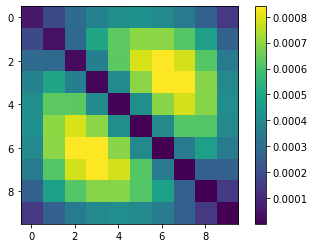

In [44]:
plt.imshow(hessian_me.detach().numpy())
plt.colorbar()

In [45]:
p_in = Particle(*sample.detach().numpy().T, s, p0c, mc2)

L_d = 1.00 # Drift length
L_q = 0.1 # Quad length 
drift = Drift(L_d)
def sigmax_end2(k1s):
    """
    returns x beamsize after lattice composed by len(k1s)+1 drifts with len(k1s) quadrupoles in between
    """
    lattice = [drift]
    for k1 in k1s:
        lattice.append(Quadrupole(L_q, k1, 1))
        lattice.append(drift)

    p_out = track_a_lattice(p_in, lattice)
    return np.std(p_out.x)

#k1s = np.array([10,-10,10,-10,10,-10,10,-10,10,-10])
k1s = np.zeros(10)

In [46]:
%%time
hessian_nd = nd.Hessian(sigmax_end2)(k1s)
hessian_nd

CPU times: user 14.2 s, sys: 0 ns, total: 14.2 s
Wall time: 14.2 s


array([[6.3504620821793246e-05, 2.0705319537947325e-04,
        3.2142334442002737e-04, 4.0122353665789318e-04,
        4.4645377208135840e-04, 4.5711405069807145e-04,
        4.3320437250516009e-04, 3.7472473750117412e-04,
        2.8167514569030292e-04, 1.5405559706843343e-04],
       [2.0705319537947325e-04, 4.7953802488688836e-05,
        3.2150311786869674e-04, 5.3265071544342636e-04,
        6.7145189934312882e-04, 7.3790666953281133e-04,
        7.3201502601599722e-04, 6.5377696877953946e-04,
        5.0319249784996011e-04, 2.8026161321108284e-04],
       [3.2142334442002737e-04, 3.2150311786869674e-04,
        3.6988654291792369e-05, 4.0349821684037358e-04,
        6.7326860594286509e-04, 8.3293987604013083e-04,
        8.8251202712529171e-04, 8.2198505920742294e-04,
        6.5135897228012934e-04, 3.7063376634657879e-04],
       [4.0122353665789318e-04, 5.3265071544342636e-04,
        4.0349821684037358e-04, 2.9403321008564866e-05,
        4.5190389185476639e-04, 7.42213670206

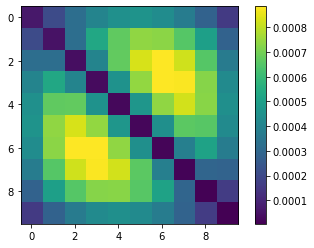

In [47]:
plt.imshow(hessian_nd)
plt.colorbar()

In [48]:
np.allclose(hessian_nd, hessian_me.detach().numpy())

False

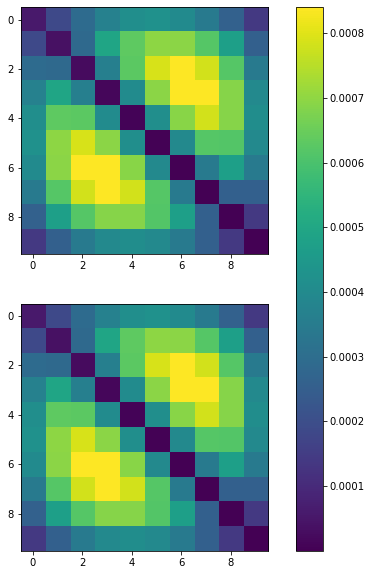

In [49]:
fig, axs = plt.subplots(2, figsize=(10,10))
axs[0].imshow(hessian_me.detach().numpy())
axs[1].imshow(hessian_nd)
fig.colorbar(axs[1].imshow(hessian_me.detach().numpy()),ax=axs)

In [50]:
dif = np.abs((hessian_me.detach().numpy()-hessian_nd)/hessian_me.detach().numpy())
np.max(dif),np.min(dif)

(167.5744920694489, 0.049776358476683776)

# misc

In [51]:
np.finfo(np.float64).eps

2.220446049250313e-16

In [52]:
torch.finfo(torch.float64).eps

2.220446049250313e-16

In [53]:
np.finfo(np.float32).eps

1.1920929e-07

In [54]:
torch.finfo(torch.float32).eps

1.1920928955078125e-07